# Compare SR Assembly Stats between 3 evaluated Bacterial Species

### Import Statements

In [107]:
import numpy as np
import pandas as pd
import vcf
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.stats

%matplotlib inline

#### Pandas Viewing Settings

In [108]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [109]:
def read_BaktaTXT_ToBasicInfoDict(i_BaktaInfo_TXT):
    """
    Function to read in a bakta.txt file. 
    
    The function extracts the following information & stores it as a dictionary:
    1) Total Cumulative Length (Across all contigs), 2) Number of contigs
    3) GC content, 4) Assembly N50, 5) Number CDS, 6) Coding Density
    """
    
    out_BaktaInfo_Dict = {}
    
    i_Asm_BaktaInfo_DF = pd.read_csv(i_BaktaInfo_TXT, sep = ":",header=None)
    i_Asm_BaktaInfo_RawDict = dict(i_Asm_BaktaInfo_DF[[0,1]].values)

    out_BaktaInfo_Dict["TotalContigLength"] = int(i_Asm_BaktaInfo_RawDict["Length"])
    out_BaktaInfo_Dict["NumContigs"] = int(i_Asm_BaktaInfo_RawDict["Count"])
    out_BaktaInfo_Dict["GCcontent"] = float(i_Asm_BaktaInfo_RawDict["GC"] )
    out_BaktaInfo_Dict["N50"] = float(i_Asm_BaktaInfo_RawDict["N50"])
    out_BaktaInfo_Dict["NumCDS"] = int( i_Asm_BaktaInfo_RawDict["CDSs"])

    out_BaktaInfo_Dict["CodingDensity"] = float(i_Asm_BaktaInfo_RawDict["coding density"])
    out_BaktaInfo_Dict["NumHypotheticals"] = int(i_Asm_BaktaInfo_RawDict['hypotheticals'])

    
    return out_BaktaInfo_Dict


## Define paths to sample metadata files & key directories

In [110]:

Proj_MainDir = "/n/data1/hms/dbmi/farhat/mm774/Projects"


### Mtb PG Analysis Files ###

Mtb_WGA_SMK_Outputs_Dir = "/n/data1/hms/dbmi/farhat/mm774/Projects/Mtb-WGA-SMK-Output"

WGA151CI_SMK_OutputDir = Mtb_WGA_SMK_Outputs_Dir + "/231121_MtbSetV3_151CI"

Mtb_SMK_Pipeline_OutputDir = WGA151CI_SMK_OutputDir
############################################################




### Ecoli PG Analysis Files ###

Ecoli_PG_MainDir = f"{Proj_MainDir}/230905_Ecoli_PG_Analysis"  

Ecoli_SMK_Outputs_Dir = f"{Ecoli_PG_MainDir}/SMK_OutDirs"
PG_Ecoli_50I_OutDir = Ecoli_SMK_Outputs_Dir + "/231011_Ecoli_Shaw2021_5OI_V1"



Ecoli_Data_MainDir = f"{Ecoli_PG_MainDir}/Data"  

Shaw2021_50Asm_Dir = f"{Ecoli_Data_MainDir}/Shaw2021.50Genomes.Data/data"
Shaw2021_Meta_TSV = f"{Ecoli_Data_MainDir}/Shaw2021.SelectedIsolates.50I.tsv"  

Ecoli_Meta_Dir = f"../../Data/230905_Ecoli_50CI_Metadata_Shaw2021"  

Shaw2021_Ecoli_50Asm_Meta_TSV = f"{Ecoli_Meta_Dir}/231011.Shaw2021.Ecoli.50I.MetaData.tsv"



############################################################




### Saureus PG Analysis Files ###

SA_PG_MainDir = f"{Proj_MainDir}/241206_Saureus_PG_Analysis"  

SA_SMK_Outputs_Dir = f"{SA_PG_MainDir}/SMK_OutDirs"

PG_SA_68I_OutDir = SA_SMK_Outputs_Dir + "/241206_Saureus_HoutakBouras2023_68I_V1"



SA_Data_MainDir = f"{SA_PG_MainDir}/Data"  

SA_68CI_GenomeFASTAs_Dir = f"{SA_Data_MainDir}/CRS.Saureus.68CI.GenomesFromGitRepo"

HoutakBouras2023_Saureus_68CI_AsmPATH_AltPath_TSV = f"{SA_PG_MainDir}/241206.HoutakBouras2023.Saureus.68I.MetaData.And.AsmFA.tsv"

Saureus_Repo_Meta_Dir = f"../../Data/241206_Saureus_HoutakBouras2023_Metadata"  

Sa_ENA_RunData_TSV = f"{Saureus_Repo_Meta_Dir}/ENA.RunMetadata.PRJNA914892.tsv"

Sa_HoutakBouras2023_Isolate_Metadata_TSV = f"{Saureus_Repo_Meta_Dir}/HoutakBouras2023.metadata.csv"

Sa_HoutakBouras2023_Isolate_MLST_Info_TSV = f"{Saureus_Repo_Meta_Dir}/metadata/poppunk_mlst.csv"

############################################################




## Parse in SA metadata

In [111]:
SA_68CI_Info_DF = pd.read_csv(HoutakBouras2023_Saureus_68CI_AsmPATH_AltPath_TSV,
                               sep = "\t")
print(SA_68CI_Info_DF.shape)

#Sa_68CI_Info_DF = pd.merge(Sa_68CI_Info_DF, MLST_DF, how = "left",
#                           left_on="SampleID", right_on = "SampleID" )

print(SA_68CI_Info_DF.shape)

(68, 8)
(68, 8)


### Define list of SA SampleIDs

In [112]:
SA_68CI_Info_DF.head(1)  

,SampleID,PatientID,Timepoint,Bioproject,SR_RunAccession,Assembly_Accession,Organism,Genome_ASM_PATH
0,C100,276,T0,PRJNA914892,SRR22859841,GCA_030290035.1,Staphylococcus aureus,/n/data1/hms/dbmi/farhat/mm774/Projects/241206...


In [113]:
SA68I_SampleIDs = SA_68CI_Info_DF["SampleID"].values   
len(SA68I_SampleIDs)

68

## Parse in Ecoli metadata

In [114]:
Shaw_50A_Info_DF = pd.read_csv(Shaw2021_Ecoli_50Asm_Meta_TSV, sep = "\t")
Shaw_50A_Info_DF.shape

(50, 24)

### Define list of Ecoli SampleIDs

In [115]:
Shaw_50A_Info_DF.head(1)  

,Isolate,Biosample Accession,Short Reads Accession,Long Reads Accession,Assembly Accession,Animal or WwTW,Isolate source information,Timepoint,Niche,Niche.2,Location,Genus,Species,ST assignment,Circularised plasmids,Number of contigs,Circularised chromosome (1=yes),Total genome size (bp),Chromosome GC (if known),Phylogroup (E. coli only),Alternative isolate name,Long read sequencing method,SampleID,Genome_ASM_PATH
0,RH02|T1-C02,SAMN15147960,SRR11948863,SRR12299015,GCA_014109125.1,Animal,Pooled pig faecal samples collected from floor...,1,Pig,Faeces,RH02,Escherichia,Escherichia coli,10.0,1,2,1,4953790,50.7,A,RHB02-C02,PacBio,GCA_014109125,/n/data1/hms/dbmi/farhat/mm774/Projects/230905...


In [116]:
E50I_SampleIDs = Shaw_50A_Info_DF["SampleID"].values   
len(E50I_SampleIDs)

50

## Parse sample Mtb Metadata (N = 151)

In [117]:
Repo_DataDir = "../../Data"
InputAsmPath_Dir = f"{Repo_DataDir}/231121.InputAsmTSVs.MtbSetV3.151CI"

MtbSetV3_151CI_InputAsmPATHs_TSV = f"{InputAsmPath_Dir}/231121.MtbSetV3.151CI.HybridAndSRAsm.FAPATHs.V1.tsv"

MtbSetV3_151CI_AsmSumm_TSV = f"{InputAsmPath_Dir}/231121.MtbSetV3.151CI.HybridAsm.AsmSummary.V2.tsv"

WGA151CI_AsmSummary_DF = pd.read_csv(MtbSetV3_151CI_AsmSumm_TSV, sep = "\t")

SampleIDs_151CI_SOI = list( WGA151CI_AsmSummary_DF["SampleID"].values )
WGA151CI_SampleIDs = SampleIDs_151CI_SOI

ID_To_PrimLineage_Dict = dict(WGA151CI_AsmSummary_DF[['SampleID', 'PrimaryLineage']].values)
ID_To_SubLineage_Dict = dict( WGA151CI_AsmSummary_DF[["SampleID", "Lineage"]].values)
ID_To_Dataset_Dict = dict(WGA151CI_AsmSummary_DF[['SampleID', 'Dataset_Tag']].values)
WGA151CI_AsmSummary_DF.shape

(151, 7)

## Define paths to all BAKTA Annotations (For both Hybrid & SR ASMs)

In [118]:
SampleTag_ToPaths_Dict = {}

### Mtb 151CI ###
listOfSample_Tags = WGA151CI_SampleIDs
target_SMK_OutputDir = Mtb_SMK_Pipeline_OutputDir

for SampleID in listOfSample_Tags:
    sample_Asm_OutputDir = f"{target_SMK_OutputDir}/AsmAnalysis/{SampleID}"
    GenomeAnno_Dir = f"{sample_Asm_OutputDir}/GenomeAnnotation"

    Bakta_LR_AsmDir = f"{GenomeAnno_Dir}/{SampleID}_Asm_Bakta"
    Bakta_SR_AsmDir = f"{GenomeAnno_Dir}/{SampleID}_SR_Asm_Bakta"

    SampleTag_ToPaths_Dict[SampleID] = {
        "Dataset": "Mtb_151CI",
        "Species": "Mtb",
        "LRAsm_Bakta_GFF": f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.gff3",
        "LRAsm_Bakta_GBFF": f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.gbff",
        "LRAsm_Bakta_FAA": f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.faa",
        "LRAsm_Bakta_FFN": f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.ffn",
        "LRAsm_Bakta_FNA": f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.fna",
        "LRAsm_Bakta_TXT": f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.txt",
        "SRAsm_Bakta_GFF": f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.gff3",
        "SRAsm_Bakta_GBFF": f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.gbff",
        "SRAsm_Bakta_FAA": f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.faa",
        "SRAsm_Bakta_FFN": f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.ffn",
        "SRAsm_Bakta_FNA": f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.fna",
        "SRAsm_Bakta_TXT": f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.txt",
    }

#########################################################################




##### Ecoli 50CI #####

listOfSample_Tags = E50I_SampleIDs
target_SMK_OutputDir = PG_Ecoli_50I_OutDir

for SampleID in listOfSample_Tags:
    sample_Asm_OutputDir = f"{target_SMK_OutputDir}/AsmAnalysis/{SampleID}"
    GenomeAnno_Dir = f"{sample_Asm_OutputDir}/GenomeAnnotation"

    sample_SR_Asm_OutputDir = f"{target_SMK_OutputDir}/SR_DataProcessing/{SampleID}"
    SR_GenomeAnno_Dir = f"{sample_SR_Asm_OutputDir}/GenomeAnnotation"

    Bakta_LR_AsmDir = f"{GenomeAnno_Dir}/{SampleID}_Asm_Bakta"
    Bakta_SR_AsmDir = f"{SR_GenomeAnno_Dir}/{SampleID}_Asm_Bakta"

    SampleTag_ToPaths_Dict[SampleID] = {
        "Dataset": "Ecoli_50CI",
        "Species": "Ecoli",
        "LRAsm_Bakta_GFF": f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.gff3",
        "LRAsm_Bakta_GBFF": f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.gbff",
        "LRAsm_Bakta_FAA": f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.faa",
        "LRAsm_Bakta_FFN": f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.ffn",
        "LRAsm_Bakta_FNA": f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.fna",
        "LRAsm_Bakta_TXT": f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.txt",
        "SRAsm_Bakta_GFF": f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.gff3",
        "SRAsm_Bakta_GBFF": f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.gbff",
        "SRAsm_Bakta_FAA": f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.faa",
        "SRAsm_Bakta_FFN": f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.ffn",
        "SRAsm_Bakta_FNA": f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.fna",
        "SRAsm_Bakta_TXT": f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.txt",
    }

#########################################################################



### Saureus 68CI ###

listOfSample_Tags = SA68I_SampleIDs
target_SMK_OutputDir = PG_SA_68I_OutDir

for SampleID in listOfSample_Tags:
    sample_Asm_OutputDir = f"{target_SMK_OutputDir}/AsmAnalysis/{SampleID}"
    GenomeAnno_Dir = f"{sample_Asm_OutputDir}/GenomeAnnotation"

    sample_SR_Asm_OutputDir = f"{target_SMK_OutputDir}/SR_DataProcessing/{SampleID}"
    SR_GenomeAnno_Dir = f"{sample_SR_Asm_OutputDir}/GenomeAnnotation"

    Bakta_LR_AsmDir = f"{GenomeAnno_Dir}/{SampleID}_Asm_Bakta"
    Bakta_SR_AsmDir = f"{SR_GenomeAnno_Dir}/{SampleID}_Asm_Bakta"

    SampleTag_ToPaths_Dict[SampleID] = {
        "Dataset": "Saureus_68CI",
        "Species": "Saureus",
        "LRAsm_Bakta_GFF": f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.gff3",
        "LRAsm_Bakta_GBFF": f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.gbff",
        "LRAsm_Bakta_FAA": f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.faa",
        "LRAsm_Bakta_FFN": f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.ffn",
        "LRAsm_Bakta_FNA": f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.fna",
        "LRAsm_Bakta_TXT": f"{Bakta_LR_AsmDir}/{SampleID}.Bakta.txt",
        "SRAsm_Bakta_GFF": f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.gff3",
        "SRAsm_Bakta_GBFF": f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.gbff",
        "SRAsm_Bakta_FAA": f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.faa",
        "SRAsm_Bakta_FFN": f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.ffn",
        "SRAsm_Bakta_FNA": f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.fna",
        "SRAsm_Bakta_TXT": f"{Bakta_SR_AsmDir}/{SampleID}.Bakta.txt",
    }
    
#########################################################################



In [119]:
SampleTag_ToPaths_Dict.keys()

dict_keys(['N0072', 'N0153', 'TB3113', 'TB1236', 'TB2659', 'TB2780', 'TB1612', 'TB2512', 'TB2981', 'TB3091', 'M0003941_3', 'TB3368', 'N0145', 'N0155', 'TB2995', 'TB3396', 'N0004', 'N1274', 'N0054', '02_R1179', '01_R1134', 'M0017522_5', 'M0016395_7', 'M0010874_7', '02_R1708', '02_R0894', '01_R1430', 'M0014888_3', '02_R1896', 'TB4620', 'TB3162', 'MT_0080', 'TB3054', 'TB3251', 'M0016737_0', 'TB2661', 'TB3237', 'TB3169', 'TB3386', 'TB3334', 'M0011368_9', 'TB2968', 'N1272', 'N1176', 'N1202', 'N1177', 'N0091', 'RW-TB008', '9050-05', '4549-04', '696-05', '702-06', '706-05', '8129-04', '3003-06', '8651-04', 'QC-3', 'QC-9', 'QC-5', 'QC-8', 'QC-10', 'QC-4', 'QC-7', 'QC-6', 'QC-1', 'mada_1-10', 'mada_2-46', 'mada_1-1', 'mada_1-36', 'mada_1-39', 'mada_1-51', 'mada_1-44', 'mada_117', 'mada_118', 'mada_122', 'mada_107', 'R27252', 'R23887', 'R30215', 'R30078', 'R29816', 'R30234', '18_0621851', 'R36431', 'R28703', 'mada_115', 'mada_2-42', 'R31095', 'R28012', 'R37765', 'R27657', 'R25048', 'R24120', 'R2

# Parse & Summarize assembly info (LR vs SR)
The code below will iterate over all samples and parse info from outputs of the analysis pipeline

## Asm Info Parsing - For all 3 species (`Mtb`, `Ecoli`, `Saureus`)

In [161]:

listOf_SampleInfoTuples = []

listOf_SampleInfoTuplesTidy = []

for SampleID, i_InfoAndFilePaths_Dict in tqdm( SampleTag_ToPaths_Dict.items() ):
    
    SampleID = row["SampleID"]
        
    i_Dataset = i_InfoAndFilePaths_Dict["Dataset"]
    i_Species = i_InfoAndFilePaths_Dict["Species"]

    
    #### LR & SR Genome Annotation #####    
    
    i_LRAsm_BaktaInfo_TXT = i_InfoAndFilePaths_Dict["LRAsm_Bakta_TXT"]
    i_SRAsm_BaktaInfo_TXT = i_InfoAndFilePaths_Dict["SRAsm_Bakta_TXT"]

    i_LRAsm_BaktaInfo_Dict = read_BaktaTXT_ToBasicInfoDict(i_LRAsm_BaktaInfo_TXT)

    LRAsm_TotalLen = i_LRAsm_BaktaInfo_Dict["TotalContigLength"] 
    LRAsm_Ncontigs = i_LRAsm_BaktaInfo_Dict["NumContigs"]
    LRAsm_GCcontent = i_LRAsm_BaktaInfo_Dict["GCcontent"]
    LRAsm_N50 = i_LRAsm_BaktaInfo_Dict["N50"]
    LRAsm_NumCDS = i_LRAsm_BaktaInfo_Dict["NumCDS"]

    i_SRAsm_BaktaInfo_Dict = read_BaktaTXT_ToBasicInfoDict(i_SRAsm_BaktaInfo_TXT)
    SRAsm_TotalLen = i_SRAsm_BaktaInfo_Dict["TotalContigLength"] 
    SRAsm_Ncontigs = i_SRAsm_BaktaInfo_Dict["NumContigs"]
    SRAsm_GCcontent = i_SRAsm_BaktaInfo_Dict["GCcontent"]
    SRAsm_N50 = i_SRAsm_BaktaInfo_Dict["N50"]
    SRAsm_NumCDS = i_SRAsm_BaktaInfo_Dict["NumCDS"]

    SRAsm_CodingDensity = i_SRAsm_BaktaInfo_Dict["CodingDensity"]

    sampleInfo_Tuple = (SampleID,
                        i_Species,
                        i_Dataset,
                        LRAsm_TotalLen,
                        LRAsm_Ncontigs,
                        LRAsm_GCcontent,
                        LRAsm_N50,
                        LRAsm_NumCDS,
                        SRAsm_TotalLen,
                        SRAsm_Ncontigs,
                        SRAsm_GCcontent,
                        SRAsm_N50,
                        SRAsm_NumCDS,)
    
    listOf_SampleInfoTuples.append(sampleInfo_Tuple)

    
    sampleInfo_TupleTidy_SR = (SampleID,
                               i_Species,
                               i_Dataset,
                               "LongRead",
                               LRAsm_TotalLen,
                               LRAsm_Ncontigs,
                               LRAsm_GCcontent,
                               LRAsm_N50,
                               LRAsm_NumCDS )

    sampleInfo_TupleTidy_LR = (SampleID,
                               i_Species,
                               i_Dataset,
                               "ShortRead",
                               SRAsm_TotalLen,
                               SRAsm_Ncontigs,
                               SRAsm_GCcontent,
                               SRAsm_N50,
                               SRAsm_NumCDS,)
    
    listOf_SampleInfoTuplesTidy.append(sampleInfo_TupleTidy_LR)
    listOf_SampleInfoTuplesTidy.append(sampleInfo_TupleTidy_SR)
    
    
AsmSummary_DF = pd.DataFrame(listOf_SampleInfoTuples)
AsmSummary_DF.columns = ["SampleID",
                         "Species",
                         "Dataset",
                        "LRAsm_TotalLen",
                        "LRAsm_Ncontigs",
                        "LRAsm_GCcontent",
                        "LRAsm_N50",
                        "LRAsm_NumCDS",
                        "SRAsm_TotalLen",
                        "SRAsm_Ncontigs",
                        "SRAsm_GCcontent",
                        "SRAsm_N50",
                        "SRAsm_NumCDS",]

#AsmSummary_DF["PrimaryLineage_coll2014"] = AsmSummary_DF["Lineage_coll2014"].str.split(".").str[0]

MES_Asm_LRvsSR_DF = AsmSummary_DF
MES_Asm_LRvsSR_DF.shape


MES_LRvsSR_TidyDF = pd.DataFrame(listOf_SampleInfoTuplesTidy)
MES_LRvsSR_TidyDF.columns = ["SampleID",
                              "Species",
                              "Dataset",
                              "AsmType",
                              "Asm_TotalLen",
                              "Asm_Ncontigs",
                              "Asm_GCcontent",
                              "Asm_N50",
                              "Asm_NumCDS",]


100%|██████████| 269/269 [00:01<00:00, 137.44it/s]


In [162]:
MES_Asm_LRvsSR_DF.head(3)

,SampleID,Species,Dataset,LRAsm_TotalLen,LRAsm_Ncontigs,LRAsm_GCcontent,LRAsm_N50,LRAsm_NumCDS,SRAsm_TotalLen,SRAsm_Ncontigs,SRAsm_GCcontent,SRAsm_N50,SRAsm_NumCDS
0,N0072,Mtb,Mtb_151CI,4421404,1,65.6,4421404.0,4051,4353633,104,65.5,120698.0,4064
1,N0072,Mtb,Mtb_151CI,4389181,1,65.6,4389181.0,4041,4331132,116,65.5,90314.0,4048
2,N0072,Mtb,Mtb_151CI,4419922,1,65.6,4419922.0,4083,4332706,114,65.6,93741.0,4058


In [163]:
MES_LRvsSR_TidyDF.head(3)

,SampleID,Species,Dataset,AsmType,Asm_TotalLen,Asm_Ncontigs,Asm_GCcontent,Asm_N50,Asm_NumCDS
0,N0072,Mtb,Mtb_151CI,ShortRead,4353633,104,65.5,120698.0,4064
1,N0072,Mtb,Mtb_151CI,LongRead,4421404,1,65.6,4421404.0,4051
2,N0072,Mtb,Mtb_151CI,ShortRead,4331132,116,65.5,90314.0,4048


In [164]:
MES_SR_TidyDF = MES_LRvsSR_TidyDF.query("AsmType == 'ShortRead'")
MES_SR_TidyDF.shape

(269, 9)

# Output stats as TSV

In [168]:
MES_Asm_LRvsSR_DF.to_csv("LRvsSR.AsmStats.3BactSpecies.tsv", sep = "\t", index=False)

In [167]:
MES_LRvsSR_TidyDF.to_csv("LRvsSR.AsmStats.3BactSpecies.Tidy.tsv", sep = "\t", index=False)

In [125]:
i_LRAsm_BaktaInfo_Dict

{'TotalContigLength': 2828747,
 'NumContigs': 1,
 'GCcontent': 32.9,
 'N50': 2828747.0,
 'NumCDS': 2624,
 'CodingDensity': 85.5,
 'NumHypotheticals': 155}

# Analysis & comparison of stats

In [165]:
MES_LRvsSR_TidyDF.head(3)

,SampleID,Species,Dataset,AsmType,Asm_TotalLen,Asm_Ncontigs,Asm_GCcontent,Asm_N50,Asm_NumCDS
0,N0072,Mtb,Mtb_151CI,ShortRead,4353633,104,65.5,120698.0,4064
1,N0072,Mtb,Mtb_151CI,LongRead,4421404,1,65.6,4421404.0,4051
2,N0072,Mtb,Mtb_151CI,ShortRead,4331132,116,65.5,90314.0,4048


/tmp/ipykernel_2998/1530198840.py:19: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(data=MES_LRvsSR_TidyDF, x="Species", y=metric, hue="AsmType",
/tmp/ipykernel_2998/1530198840.py:19: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(data=MES_LRvsSR_TidyDF, x="Species", y=metric, hue="AsmType",
/tmp/ipykernel_2998/1530198840.py:19: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(data=MES_LRvsSR_TidyDF, x="Species", y=metric, hue="AsmType",
/tmp/ipykernel_2998/1530198840.py:19: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(data=MES_LRvsSR_TidyDF, x="Species", y=metric, hue="AsmType",
/tmp/ipykernel_2998/1530198840.py:19: Future

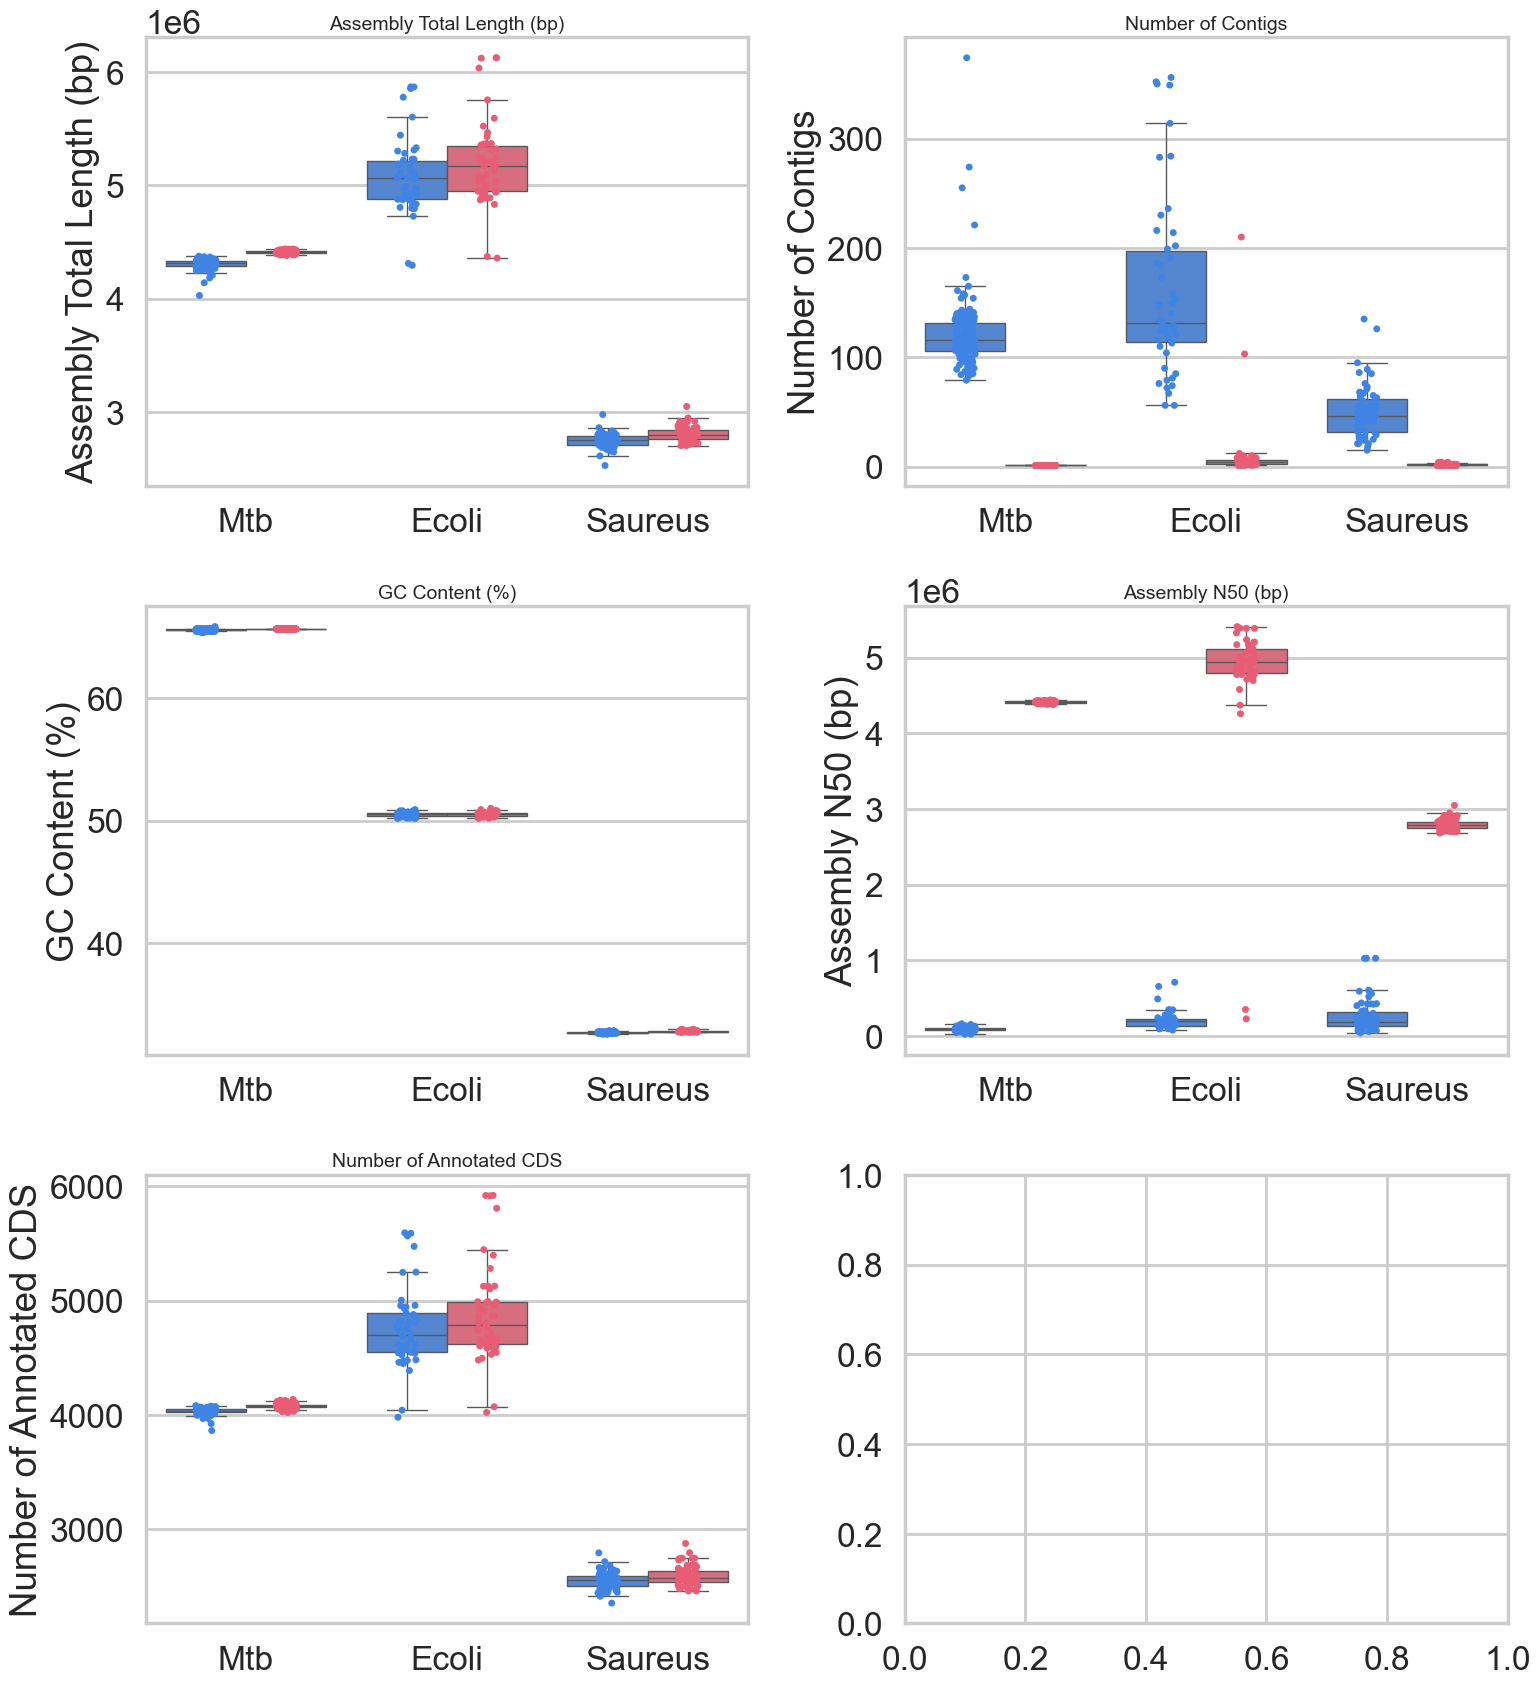

In [173]:
# Define the list of metrics to plot
metrics = ["Asm_TotalLen", "Asm_Ncontigs", "Asm_GCcontent", "Asm_N50", "Asm_NumCDS"]
metric_labels = {
    "Asm_TotalLen": "Assembly Total Length (bp)",
    "Asm_Ncontigs": "Number of Contigs",
    "Asm_GCcontent": "GC Content (%)",
    "Asm_N50": "Assembly N50 (bp)",
    "Asm_NumCDS": "Number of Annotated CDS"
}

# Plot boxplots with jitter points for each metric
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 18))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    ax = axes[i]
    sns.boxplot(data=MES_LRvsSR_TidyDF, x="Species", y=metric, hue="AsmType", 
                palette=["#3F84E5", "#E85D75"], ax=ax, fliersize=0)
    sns.stripplot(data=MES_LRvsSR_TidyDF, x="Species", y=metric, hue="AsmType", 
                  dodge=True, linewidth=0, edgecolor='gray', palette=["#3F84E5", "#E85D75"], ax=ax)
    ax.set_title(metric_labels[metric], fontsize=14)
    ax.set_xlabel("")
    ax.set_ylabel(metric_labels[metric])
    #if i < len(metrics) - 1:  # Remove legend for all but the last plot
    ax.get_legend().remove()

# Adjust layout and add a single legend
#handles, labels = ax.get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper right', bbox_to_anchor = (2,1), ncol=4, title="Assembly Type")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [ ]:
fig, axs = plt.subplots(3, 2, figsize= (11, 16), sharex=True)
#sns.set_context("paper")
#sns.set_context("paper", font_scale=2)
#sns.set_style(None)
sns.set_context("poster", font_scale=1.1)

#sns.set()

sns.boxplot(y = "Asm_TotalLen", x = "AsmType", data = MES_LRvsSR_TidyDF,
            fliersize=0, ax = axs[0][0], palette = ["#3F84E5", "#E85D75"], boxprops=dict(alpha=0.7))
sns.stripplot(y = "Asm_TotalLen", x = "AsmType", data = WGA151CI_Asm_LRvsSR_TidyDF,
              linewidth=0, edgecolor='gray', ax = axs[0][0], palette = ["#3F84E5", "#E85D75"])
axs[0][0].set_ylabel("Cumulative assembly size (bp)")

sns.boxplot(y = "Asm_NumCDS", x = "AsmType", data = MES_LRvsSR_TidyDF,
            fliersize=0, ax = axs[0][1], palette = ["#3F84E5", "#E85D75"], boxprops=dict(alpha=0.7))
sns.stripplot(y = "Asm_NumCDS", x = "AsmType", data = MES_LRvsSR_TidyDF,
              linewidth=0, edgecolor='gray', ax = axs[0][1], palette = ["#3F84E5", "#E85D75"])
axs[0][1].set_ylabel("# of annotated CDS")

sns.boxplot(y = "Asm_N50", x = "AsmType", data = MES_LRvsSR_TidyDF,
            fliersize=0, ax = axs[1][0], palette = ["#3F84E5", "#E85D75"], boxprops=dict(alpha=0.7))
sns.stripplot(y = "Asm_N50", x = "AsmType", data = MES_LRvsSR_TidyDF,
              linewidth=0, edgecolor='gray', ax = axs[1][0], palette = ["#3F84E5", "#E85D75"])
axs[1][0].set_ylabel("Assembly N50 (bp)")

sns.boxplot(y = "Asm_Ncontigs", x = "AsmType", data = MES_LRvsSR_TidyDF,
            fliersize=0, ax = axs[1][1], palette = ["#3F84E5", "#E85D75"], boxprops=dict(alpha=0.7))
sns.stripplot(y = "Asm_Ncontigs", x = "AsmType", data = v,
              linewidth=0, edgecolor='gray', ax = axs[1][1], palette = ["#3F84E5", "#E85D75"])
axs[1][1].set_ylabel("# contigs")

sns.boxplot(y = "Asm_GCcontent", x = "AsmType", data = MES_LRvsSR_TidyDF,
            fliersize=0, ax = axs[2][0], palette = ["#3F84E5", "#E85D75"], boxprops=dict(alpha=0.7))
sns.stripplot(y = "Asm_GCcontent", x = "AsmType", data = MES_LRvsSR_TidyDF,
              linewidth=0, edgecolor='gray', ax = axs[2][0], palette = ["#3F84E5", "#E85D75"])
axs[2][0].set_ylabel("Genome GC%")


axs[0][0].set_xlabel("")
axs[0][1].set_xlabel("")
axs[1][0].set_xlabel("")
axs[1][1].set_xlabel("")
axs[2][0].set_xlabel("")
axs[2][1].set_xlabel("")

sns.despine()

#plt.savefig("Results1_Plots/S2.CompleteVsSR.AsmStats.png", dpi = 300)
#plt.savefig("Results1_Plots/S2.CompleteVsSR.AsmStats.svg")

plt.show()


In [132]:
MES_LRvsSR_TidyDF.groupby(["Species", "AsmType"]).describe()["Asm_TotalLen"][["25%","50%","75%"]]

25%        50%         75%
Species AsmType                                     
Ecoli   LongRead   4949721.00  5171405.5  5347290.75
        ShortRead  4876901.75  5061643.5  5212460.25
Mtb     LongRead   4407115.50  4413185.0  4420762.00
        ShortRead  4289080.50  4314468.0  4335781.00
Saureus LongRead   2759938.50  2798712.5  2837675.75
        ShortRead  2709775.25  2753337.5  2787940.75

In [148]:
MES_LRvsSR_TidyDF.groupby(["Species", "AsmType"])[["Asm_TotalLen", "Asm_NumCDS"]].mean()

Asm_TotalLen   Asm_NumCDS
Species AsmType                             
Ecoli   LongRead   5.188887e+06  4866.940000
        ShortRead  5.079807e+06  4751.200000
Mtb     LongRead   4.412729e+06  4077.370861
        ShortRead  4.308387e+06  4031.966887
Saureus LongRead   2.806825e+06  2590.691176
        ShortRead  2.746150e+06  2550.323529

In [152]:
(4.412729 - 4.308387) * 100000

10434.199999999993

In [153]:
(5.188887 - 5.079807) * 100000

10908.000000000051

In [154]:
(2.806825 - 2.746150) * 100000

6067.499999999981

In [141]:
4413185 - 4314468

98717

In [142]:
5171405.5 - 5061643.5

109762.0

In [129]:
MES_LRvsSR_TidyDF.groupby(["Species", "AsmType"]).describe()["Asm_Ncontigs"][["25%","50%","75%"]]

25%    50%    75%
Species AsmType                        
Ecoli   LongRead     2.00    4.0    6.0
        ShortRead  113.75  131.0  197.0
Mtb     LongRead     1.00    1.0    1.0
        ShortRead  105.50  116.0  131.5
Saureus LongRead     1.00    2.0    2.0
        ShortRead   31.75   46.0   61.5

In [140]:
#MES_LRvsSR_TidyDF.groupby(["Species", "AsmType"]).describe()["Asm_N50"][["25%","50%","75%"]]

In [127]:
MES_LRvsSR_TidyDF.groupby(["Species", "AsmType"]).describe()["Asm_NumCDS"][["25%","50%","75%"]]

25%     50%      75%
Species AsmType                            
Ecoli   LongRead   4619.75  4790.0  4989.25
        ShortRead  4545.25  4701.0  4887.00
Mtb     LongRead   4065.00  4074.0  4088.00
        ShortRead  4022.00  4035.0  4046.00
Saureus LongRead   2534.50  2572.0  2635.00
        ShortRead  2499.75  2552.5  2589.00

In [126]:
MES_LRvsSR_TidyDF.groupby(["Species", "AsmType"]).describe()["Asm_GCcontent"][["25%","50%","75%"]]

25%    50%   75%
Species AsmType                     
Ecoli   LongRead   50.4  50.55  50.6
        ShortRead  50.4  50.50  50.6
Mtb     LongRead   65.6  65.60  65.6
        ShortRead  65.5  65.50  65.6
Saureus LongRead   32.8  32.80  32.9
        ShortRead  32.7  32.70  32.8

In [135]:
MES_SR_TidyDF.groupby(["Species", "AsmType"]).describe()["Asm_TotalLen"][["25%","50%","75%"]]

,,25%,50%,75%
Species,AsmType,,,
Ecoli,ShortRead,4876901.75,5061643.5,5212460.25
Mtb,ShortRead,4289080.50,4314468.0,4335781.00
Saureus,ShortRead,2709775.25,2753337.5,2787940.75


In [136]:
MES_SR_TidyDF.groupby(["Species", "AsmType"]).describe()["Asm_Ncontigs"][["25%","50%","75%"]]

,,25%,50%,75%
Species,AsmType,,,
Ecoli,ShortRead,113.75,131.0,197.0
Mtb,ShortRead,105.50,116.0,131.5
Saureus,ShortRead,31.75,46.0,61.5


In [137]:
MES_SR_TidyDF.groupby(["Species", "AsmType"]).describe()["Asm_N50"][["25%","50%","75%"]]

,,25%,50%,75%
Species,AsmType,,,
Ecoli,ShortRead,136628.00,195558.5,225380.25
Mtb,ShortRead,73046.50,92078.0,107113.50
Saureus,ShortRead,130914.75,190728.5,320868.75


In [138]:
MES_SR_TidyDF.groupby(["Species", "AsmType"]).describe()["Asm_NumCDS"][["25%","50%","75%"]]

,,25%,50%,75%
Species,AsmType,,,
Ecoli,ShortRead,4545.25,4701.0,4887.0
Mtb,ShortRead,4022.00,4035.0,4046.0
Saureus,ShortRead,2499.75,2552.5,2589.0


In [139]:
MES_SR_TidyDF.groupby(["Species", "AsmType"]).describe()["Asm_GCcontent"][["25%","50%","75%"]]

,,25%,50%,75%
Species,AsmType,,,
Ecoli,ShortRead,50.4,50.5,50.6
Mtb,ShortRead,65.5,65.5,65.6
Saureus,ShortRead,32.7,32.7,32.8


In [103]:
#!ls -1 /n/data1/hms/dbmi/farhat/mm774/Projects/230905_Ecoli_PG_Analysis/SMK_OutDirs/231011_Ecoli_Shaw2021_5OI_V1


In [86]:
!ls -1 /n/data1/hms/dbmi/farhat/mm774/Projects/230905_Ecoli_PG_Analysis/SMK_OutDirs/231011_Ecoli_Shaw2021_5OI_V1/AsmAnalysis/GCA_014109125/GenomeAnnotation/GCA_014109125_SR_Asm_Bakta/GCA_013602835



ls: cannot access /n/data1/hms/dbmi/farhat/mm774/Projects/230905_Ecoli_PG_Analysis/SMK_OutDirs/231011_Ecoli_Shaw2021_5OI_V1/AsmAnalysis/GCA_014109125/GenomeAnnotation/GCA_014109125_SR_Asm_Bakta/GCA_013602835: No such file or directory


In [92]:
!ls -1 /n/data1/hms/dbmi/farhat/mm774/Projects/230905_Ecoli_PG_Analysis/SMK_OutDirs/231011_Ecoli_Shaw2021_5OI_V1/SR_DataProcessing/GCA_013602835/GenomeAnnotation



GCA_013602835_Asm_Bakta
